## Suggested Solver

**Note: This is only a suggested way of solving the problem. This solution is in no way complete and needs significant improvements, something we hope the competition participants will be able to do.**

**Step 1.** First convert all features into objective features - this makes modeling easier. To do this, assign a numeric value to every string. For example ```'F13': {'DB1': 4, 'DB2': 2, 'DB3': 0, 'DB4': 3, 'DB5': 1}```

**Step 2.** Calculate benchmark returns for every period as wi`*`Ri and break end of period TRR into three buckets: over perform index(TRR>wi`*`Ri), under perform index, +ve(TRR<wi`*`Ri, TRR>0), underperform index -ve (TRR<wi`*`Ri, TRR<0)
Create a target variable `Y` and assign the following values: over perform index: 1 under perform index but +ve return: 0 underperform index and -ve return: -1

**Step 3.** Train a model which uses the given features to predict which bucket the performance will be in, use F to predict `Y`. Train a few models to check which one is the best.

**Step 4.** Define a new optimization objective function as wt`*`Ypred - transaction costs (We want as much weight as possible to be assigned to highest bucket). Run a model that first uses all the features (obviously not TRR!) to generate Ypred and then an optimizer to maximize this reward while meeting constraints.

Below is a simple implementation of this model. Suggested improvements could be:
1. Break performance into more granular buckets
2. Use a better training mechanism to predict Y (or more feature engineering before predictions
3. Define a better optimization objective function
4. Use a better optimization method


In [1]:
import pandas as pd
import numpy as np
import os.path
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen

In [42]:
## This calculates the reward, Do not change this function
def getReward(wt, wt_1, ri, l, k):
    if (ri is None) or (wt is None):
        port_returns.append(0)
        sharpe_ratio.append(0)
        port_volatility.append(0)
        reward = 0
    else:
        ri.fillna(0, inplace=True)
        returns = np.dot(wt, ri)
        port_returns.append(returns)
        downside_returns = [x for x in port_returns if x < 0]
        volatility = np.std(downside_returns) #np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = np.sqrt(12)*np.mean(port_returns) / volatility if volatility!=0 else 0
        sharpe_ratio.append(sharpe)
        port_volatility.append(volatility)
        if (wt_1 is None):
            phi = 0
        else:
            ix = wt.index | wt_1.index
            tn = wt.reindex(ix) - wt_1.reindex(ix)
            tn[tn.isnull()&tn.index.isin(wt.index)] = wt
            tn[tn.isnull()&tn.index.isin(wt_1.index)] = -wt_1
            phi = k*tn.abs().sum()
        reward = returns - l*volatility - phi
#         print('returns, volatility, phi, sharpe, reward')
#         print(returns, volatility, phi, sharpe, reward)
    return reward

## Do not change this function, this verifies if all constraints are met
def checkConstraints(wt, wt_1, wi, Dt, St, Qt, g, U, t, T, P, delta, chi, eta):
    violated = False
    tol = 0.009
    if np.abs(wt.sum()-1)>tol:
        print(wt.sum())
        print("Fully Invested Constraint Violated: Sum of weights is not 1")
        violated = True
    div_constraint = np.maximum(g, 1/float(Qt.sum()))
    if (wt.abs()-div_constraint>tol).any():
        print(wt[(wt.abs()-div_constraint>tol)])
        print("Diversification Constraint Violated: All weights are not less than parameter %.2f"%div_constraint )
        violated = True
    if wt_1 is None:
        turnover = 0
    else:
        ix = wt.index | wt_1.index
        tn = wt.reindex(ix) - wt_1.reindex(ix)
        tn[tn.isnull()&tn.index.isin(wt.index)] = wt
        tn[tn.isnull()&tn.index.isin(wt_1.index)] = -wt_1
        turnover = (tn).abs().sum()/2
    turnover_list.append(turnover)
    if (np.sum(turnover_list[-12:])>U):
        print("%0.2f Turnover Constraint Violated: Turnover Limit exceeded"%np.sum(turnover_list[-12:]))
        violated = True
    if (wt<t).any():
        print("Shortsell Constraint Violated: all weights are not greater than parameter t")
        violated = True
    if wt[wt<0].sum()<T:
        print("Max Shortsell Constraint Violated: sum of all weights are not greater than parameter T")
        violated = True
    if wt[wt!=0].count() < np.minimum(P, len(wt)):
        print("Min number of positions Constraint Violated: count of all weights <>0 %i are not greater than parameter P%i"%(wt[wt!=0].count(), np.minimum(P, len(wt))))
        violated = True
    if np.abs((wt*Dt).sum()/ (wi*Dt).sum()  - 1) - delta > tol:
        print("Duration Constraint Violated: wt*Dt/ wi*Dt %.2f is greater than parameter delta"%((wt*Dt).sum()/ (wi*Dt).sum()))
        violated = True
    if np.abs((wt*St).sum()/ (wi*St).sum() -1) - chi > tol:
        print("Spread Constraint Violated: wt*St/ wi*St %.2f is greater than parameter chi"%((wt*St).sum()/ (wi*St).sum()))
        violated = True
    if (wt*(1-Qt)).abs().sum()>tol:
        print("Qualification Constraint Violated: wt*(1-qt) is not zero %.2f"%(wt*(1-Qt)).abs().sum())
        violated = True
#     if returns - Rlow/ volatility <= np.sqrt(1-eta):
#         print("Max Risk probability Constraint Violated: returns - Rlow/ volatility <= np.sqrt(1-eta)")
            
    return violated

## Do not change this function, this verifies if final constraints are met
def checkFinalConstraints(Rmin, volmax):
    violated = False
    if np.sum(port_returns)<Rmin:
        print("Total Return Constraint Violated: Total Return is less than Index Return")
        violated = True
    if port_volatility[-1]>volmax:
        print("Volatility Constraint Violated: Vol is higher than Index Vol")
        violated = True
    if sharpe_ratio[-1]<Rmin/volmax:
        print("Sharpe Ratio Constraint Violated: SR is less than Index SR")
        violated = True
        return violated

In [3]:
def getSymbolsToTrade():
    ################################################
    ####   COPY FROM BELOW INTO TEMPLATE FILE   ####
    ################################################
    
    return 'G1'

In [4]:
index = getSymbolsToTrade()
if not os.path.isfile('%s.csv'%index):
    downloadFile(index)
idx_data = pd.read_csv('%s.csv'%index, index_col='TimeStamp')
idx_data.sort_index(axis=0, level=None, ascending=True, inplace=True)
print(idx_data.size)
idx_data=idx_data[~idx_data.duplicated()]
print(idx_data.size)
print("Data Column Names:")
print(idx_data.columns)
print(index, idx_data.index[0], idx_data.index[-1])
print(idx_data.head(10))

24953246
24953246
Data Column Names:
Index([u'AssetGroup', u'Identifier', u'F2', u'F3', u'F4', u'F5', u'q', u'F7',
       u'F8', u'd', u'S', u'F11', u'F12', u'F13', u'F14', u'F15', u'F16',
       u'F17', u'wI', u'F19', u'TRR', u'ERR', u'Q1', u'Q2', u'Q3', u'Q4',
       u'Q5', u'Q6', u'Q7', u'Q8', u'Q9', u'Q10', u'Q11', u'Q12'],
      dtype='object')
('G1', '1996-12-31', '2018-11-30')
           AssetGroup Identifier        F2              F3  \
TimeStamp                                                    
1996-12-31         G1   57c9946c  f5251e0b          Retail   
1996-12-31         G1   e7e41e26  68f41001         Leisure   
1996-12-31         G1   44b6b048  43320fca  Transportation   
1996-12-31         G1   4f59ae16  232884f1          Retail   
1996-12-31         G1   5a58ffea  d3fb19a2  Basic Industry   
1996-12-31         G1   960368a4  bd94d39c  Basic Industry   
1996-12-31         G1   2cb8cd83  68f41001         Leisure   
1996-12-31         G1   7b33849d  17978aa4  Transportat

## Suggested Solver

Step 1. convert all features into objective features

In [5]:
for c in idx_data.columns:
    if idx_data[c].dtype==object:
        print(c, idx_data[c].dtype)

('AssetGroup', dtype('O'))
('Identifier', dtype('O'))
('F2', dtype('O'))
('F3', dtype('O'))
('F4', dtype('O'))
('F7', dtype('O'))
('F12', dtype('O'))
('F13', dtype('O'))


In [6]:
listf = ['F3', 'F4', 'F7', 'F12', 'F13']
feature_dict ={}
for feature in listf:    
    fs = idx_data[feature].unique()
    f_dict = {}
    count = 0
    for f in fs:
        idx_data[feature][idx_data[feature]==f] = count
        f_dict[f] = count
        count = count+1
    feature_dict[feature] = f_dict

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
feature_dict

{'F12': {'1201-2401': 3, '201-601': 1, '2401+': 4, '601-1201': 2, '<201': 0},
 'F13': {'DB1': 0, 'DB2': 1, 'DB3': 2, 'DB4': 3, 'DB5': 4},
 'F3': {'Automotive': 14,
  'Basic Industry': 3,
  'Capital Goods': 10,
  'Consumer Goods': 9,
  'Energy': 4,
  'Financial Services': 15,
  'Healthcare': 6,
  'Insurance': 13,
  'Leisure': 1,
  'Media': 7,
  'Real Estate': 11,
  'Retail': 0,
  'Services': 8,
  'Technology & Electronics': 12,
  'Telecommunications': 5,
  'Transportation': 2},
 'F4': {'Advertising': 54,
  'Aerospace/Defense': 28,
  'Air Transportation': 2,
  'Auto Loans': 56,
  'Auto Parts & Equipment': 48,
  'Automakers': 50,
  'Beverage': 22,
  'Building & Construction': 45,
  'Building Materials': 42,
  'Cable & Satellite TV': 9,
  'Chemicals': 20,
  'Cons/Comm/Lease Financing': 52,
  'Department Stores': 0,
  'Discount Stores': 19,
  'Diversified Capital Goods': 16,
  'Electronics': 44,
  'Energy - Exploration & Production': 17,
  'Environmental': 11,
  'Food & Drug Retailers': 39,

#### Step 2. break end period TRR into three buckets: over perform index, under perform index, +ve, underperform index -ve
Create a target variable 'Y' and assign the following values:
over perform index: 1
under perform index but +ve return: 0
underperform index and -ve return: -1

In [27]:
dates = idx_data.index.unique()
idx_returns = pd.Series(0.0,index=dates)
counter=0
new_idx_data = pd.DataFrame(columns=idx_data.columns)
while counter < len(dates):
    date = dates[counter]
    date_data = idx_data[idx_data.index == date]
    
    ## get all the identifiers for a date
    
    date_data.set_index( date_data['Identifier'], inplace=True)
    date_data = date_data[~date_data.index.duplicated()]
    
    wi = pd.Series(date_data['wI']/100, index = date_data['Identifier'])
    ri = pd.Series(date_data['TRR'], index = date_data['Identifier'])
    idx_returns[date]=np.dot(wi, ri)
    
    date_data.set_index(date +'-'+date_data['Identifier'], inplace=True)
    date_data.loc[date_data['TRR']<idx_returns[date], 'Y'] = 0
    date_data.loc[date_data['TRR']<0, 'Y'] = -1
    date_data.loc[date_data['TRR']>=idx_returns[date], 'Y'] = 1
    new_idx_data = new_idx_data.append(date_data)
    counter = counter+1


#### Step 3. Train a model which uses the given features to predict which bucket the performance will be in. Train a few models to check which one is the best

In [28]:
X = new_idx_data.copy()
del X['TRR']
del X['AssetGroup']
del X['Identifier']
del X['Y']
del X['F2']
y = new_idx_data['Y'].copy()
X['NAs'] = X.isnull().sum(axis=1)
X = X.replace([np.inf, -np.inf], np.nan)
X.fillna(-50, inplace=True)


In [29]:
print(y.value_counts())

 1.0    367951
 0.0    186095
-1.0    179873
Name: Y, dtype: int64


Random under-sampling:
 1.0    186095
 0.0    186095
-1.0    179873
Name: Y, dtype: int64


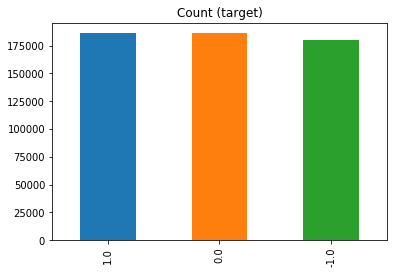

In [32]:
# Class count
count_class_0, count_class_1 , count_class_2 = y.value_counts()

# Divide by class
df_class_0 = X[y == 1]
df_class_1 = X[y == 0]
df_class_2 = X[y == -1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1, df_class_2], axis=0)
df_y_under = pd.concat([y[y.index.isin(df_class_0_under.index)], y[y == 0], y[y == -1]], axis=0)

print('Random under-sampling:')
print(df_y_under.value_counts())

df_y_under.value_counts().plot(kind='bar', title='Count (target)')

In [33]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(df_test_under, df_y_under, random_state = 10) 

In [34]:
 # training a DescisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 

# accuracy on X_test 
accuracy = dtree_model.score(X_test, y_test) 
print accuracy

# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions)
cm

0.5442340018548574


array([[21272,  7426, 16205],
       [ 6262, 26785, 13442],
       [ 5317, 14251, 27056]])

In [38]:
from sklearn.ensemble import RandomForestClassifier
rforest_model = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0).fit(X_train, y_train) 
rforest_predictions = rforest_model.predict(X_test) 

# accuracy on X_test 
accuracy = rforest_model.score(X_test, y_test) 
print accuracy

# creating a confusion matrix 
cm = confusion_matrix(y_test, rforest_predictions)
cm

0.519352828657547


array([[25459, 11946,  7384],
       [ 7571, 30494,  8238],
       [12129, 19069, 15726]])

In [43]:
rforest_model.feature_importances_

array([2.23716503e-01, 1.90602313e-01, 1.44858493e-01, 1.03409028e-01,
       3.55583099e-03, 4.69643580e-02, 2.64863796e-03, 2.55140716e-02,
       1.09587306e-02, 1.57508165e-03, 1.03123517e-03, 2.29018657e-05,
       0.00000000e+00, 8.08035835e-04, 0.00000000e+00, 0.00000000e+00,
       3.17135320e-05, 5.67719393e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.65762112e-03, 9.08669335e-05, 0.00000000e+00,
       0.00000000e+00, 7.14915203e-05, 2.65634883e-02, 2.07411294e-01,
       7.85407600e-03, 8.65087324e-05, 0.00000000e+00])

In [13]:
# # dividing X, y into train and test data 
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 
  
# # training a linear SVM classifier 
# from sklearn.svm import SVC 
# svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
# svm_predictions = svm_model_linear.predict(X_test) 
  
# # model accuracy for X_test   
# accuracy = svm_model_linear.score(X_test, y_test) 
  
# # creating a confusion matrix 
# cm = confusion_matrix(y_test, svm_predictions) 
# cm

In [37]:
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(df_test_under, df_y_under, random_state = 50) 
  
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7, weights='distance').fit(X_train, y_train) 
  
# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print accuracy 
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions) 
cm

0.45273011824715975


array([[20304, 10753, 13732],
       [ 9189, 24869, 12245],
       [14666, 14947, 17311]])

In [40]:
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(df_test_under, df_y_under, random_state = 25) 
  
# training a Naive Bayes classifier 
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test) 
  
# accuracy on X_test 
accuracy = gnb.score(X_test, y_test) 
print accuracy 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, gnb_predictions) 
cm

0.4482089033155576


array([[27898, 17034,    71],
       [12388, 33827,   145],
       [22579, 23939,   135]])

In [16]:
### Taking ensemble of all three

y_avg = (gnb_predictions+knn_predictions+dtree_predictions)/3
y_avg = [1 if x>0.5 else x for x in y_avg]
y_avg = [-1 if x<-0.5 else x for x in y_avg]
y_avg = [0 if (x>=-0.5)and(x<=0.5) else x for x in y_avg]
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_avg))
cm = confusion_matrix(y_test, y_avg) 
cm


0.393861994652193


array([[ 197, 3201, 2826],
       [ 161, 3124, 2515],
       [ 351, 6134, 6548]])

#### Step 4. Define a new optimization objective function as wt*bucketValue - transaction costs (We want as much weight as possible to be assigned to highest bucket). Train an optimizer to maximize this reward while meeting constraints

In [44]:
#     ### In this sample case, I am using scipy.optimize 
from scipy.optimize import minimize
# import cvxpy as cp

In [45]:
## Here I define my objective function 

class CustomFeatures():
    
    def newFeature1(self, wt, wt_1, ri, k):
    ################################################
    ####   COPY FROM BELOW INTO TEMPLATE FILE   ####
    ################################################
#         ri = kwargs['ri']
#         wt = kwargs['wt']
#         wt_1 = kwargs['wt_1']
#         l = kwargs['l']
        ri.fillna(0, inplace=True)
        returns = np.dot(wt, ri)
#         volatility = np.std(port_returns) #np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        weights = pd.Series(wt, index = ri.index)
    
        if (wt_1 is None):
            phi = 0
        else:
            ix = weights.index | wt_1.index
            tn = weights.reindex(ix) - wt_1.reindex(ix)
            tn[tn.isnull()&tn.index.isin(weights.index)] = weights
            tn[tn.isnull()&tn.index.isin(wt_1.index)] = -wt_1
            phi = k*tn.abs().sum()
        reward = -(returns - phi)
        return reward

In [51]:
def getWeights(identifiers, reward, wi, Dt, St, Qt, g, U, t, T, P, delta, chi, eta, df, trr, wt_1,**kwargs):
    ################################################
    ####   COPY FROM BELOW INTO TEMPLATE FILE   ####
    ################################################
    
    ### I predict future returns as returns from t-1
    ri = getPrediction(identifiers, wi, Dt, St, Qt, g, U, t, T, P, delta, chi, eta, df=df)
    
    div_constraint = np.maximum(g, 1/float(Qt.sum()))
    
    allowed = Qt[Qt==1].index   ###pre=process to assign weights only where Qt==1, this takes care of last constraint automatically
    
    bounds = ((t,div_constraint),) * len(allowed) #limits on weights
    
    cons = ({'type': 'eq', 'fun': lambda wt: 1.0 - np.sum(wt)},   ##sum of weights should be 1
            {'type': 'ineq', 'args': (P, Qt,),'fun': lambda wt, P, Qt: np.count_nonzero(wt) - np.minimum(P, Qt.sum())}, ## minimum number of positions should be P
            {'type': 'ineq', 'args': (delta, wi, Dt,),'fun': lambda wt, delta, wi, Dt: delta - np.abs((wt*Dt[Qt==1]).sum()/ (wi*Dt).sum() - 1)}, # duration should be within a % of index
            {'type': 'ineq', 'args': (chi, wi, St,),'fun': lambda wt, chi, wi, St: chi - np.abs((wt*St[Qt==1]).sum()/ (wi*St).sum() - 1)}, # spread should be within a % of index
#             {'type': 'eq', 'args': (Qt,),'fun': lambda wt, Qt: (wt*(1-Qt[Qt==1])).sum()} #only trade Q==1 assets
           )
    ## optimization function is defined in custom feature
    CustomFeaturesCls = CustomFeatures()
    weights = minimize(CustomFeaturesCls.newFeature1, wi[Qt==1], args=(wt_1, ri[Qt==1], k,), method='SLSQP', bounds=bounds,constraints=cons,
                      options={'maxiter': 500, 'ftol': 1e-06, 'iprint': 1, 'disp': True})   
    print(weights.success, weights.message)
    
    w = pd.Series(0, index = date_data['Identifier'])
    w[qt==1] = pd.Series(weights.x , index = allowed) ## assets with q==1 are assigned weights, rest are zero
    return w

In [52]:
def getKwargs():   
    return {}

In [53]:
## Step 3: Optional: Fill in the logic to return predictions for return on asset
## This function takes in the same inputs as getWeights()

### do not change the inputs to the function. If you want any extra inputs, specify them as **kwargs
### you can lookup this tutorial on how to use **kwargs https://www.geeksforgeeks.org/args-kwargs-python/

def getPrediction(identifiers, wi, Dt, St, Qt, g, U, t, T, P, delta, chi, eta, **kwargs):
    ################################################
    ####   COPY FROM BELOW INTO TEMPLATE FILE   ####
    ################################################
    
    X = kwargs['df'].copy()
    del X['AssetGroup']
    del X['Identifier']
    del X['F2']
    X['NAs'] = X.isnull().sum(axis=1)
    X = X.replace([np.inf, -np.inf], np.nan)
    X.fillna(-50, inplace=True)
#     y1 = dtree_model.predict(X)
#     y2 = knn.predict(X)
#     y3 = gnb.predict(X)
    
#     y_avg = (y1+y2+y3)/3
#     y_avg = [1 if x>0.5 else x for x in y_avg]
#     y_avg = [-1 if x<-0.5 else x for x in y_avg]
#     y_avg = [0 if (x>=-0.5)and(x<=0.5) else x for x in y_avg]

    y = rforest_model.predict(X)
    
    ri = pd.Series(y, index = date_data['Identifier'])
    
    return ri

In [54]:
# empty lists to store returns, volatility and weights of imaginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
asset_weights = []
reward_list = []
turnover_list = []
idx_returns = []

#port_returns ,port_volatility ,sharpe_ratio ,asset_weights ,reward_list ,turnover_list ,idx_returns 

#empty df to store previous period returns
ri = None

#empty dict to store values by date
dict_metrics_by_date = {}


In [ ]:
### Evaluator to getweights at everytime t and calcuate reward + check if constraints are met

## specifying all the constants
counter = 0
l = 0.1
k = 0.03
g = 0.04
U = 2.5
t= 0
T = 0
P = 50
delta = 0.5
chi = 0.15
eta = 0.95

## initializing arrays
dates = idx_data.index.unique()
wi = None

## looping over all dates
while counter < len(dates):
    date = dates[counter]
    
    print('################# \nDATE %s'%date)
    
    ## load all the data for a date
    date_data = idx_data[idx_data.index == date]
    
    ## get all the identifiers for a date
    
    date_data.set_index( date_data['Identifier'], inplace=True)
    date_data = date_data[~date_data.index.duplicated()]
    cusips = date_data['Identifier']
    
    ## old weights
    wt_1 = asset_weights[-1] if len(asset_weights)>0 else None
    wt_2 = asset_weights[-2] if len(asset_weights)>1 else None
    
    ##old index weights
    wi_t_1 = None if wi is None else wi.copy()
    
    ## calculate reward at start of time t from weights allocated at time t-1
    reward = getReward(wt_1, wt_2, ri, l, k)
    
    ## calculate index return at start of time t from weights allocated at time t-1
    if ri is None or wi_t_1 is None:
        idx_returns.append(0)
    else:
        idx_returns.append(np.dot(wi_t_1, ri))
    
    #load specific feature info for time t
    wi = pd.Series(date_data['wI']/100, index = date_data['Identifier'])
    Dt = pd.Series(date_data['d'], index = date_data['Identifier'])
    St = pd.Series(date_data['S'], index = date_data['Identifier'])
    qt = pd.Series(date_data['q'], index = date_data['Identifier'])
    
    ## get new weights
    wt = getWeights(cusips, reward, wi, Dt, St, qt, g, U, t, T, P, delta, chi, eta, \
                        date_data.drop(columns=['TRR']), ri, wt_1, **getKwargs()) 

    
    ## store relevant info in their lists
    asset_weights.append(wt)
    reward_list.append(reward)
    
    ## verify if all constraints are met
    if checkConstraints(wt, wt_1, wi, Dt, St, qt, g, U, t, T, P, delta, chi, eta):
        print("ERROR!!!! weights don't meet contraints, exiting")
#         break
    
    dict_metrics_by_date[date] = {'returns': port_returns[-1],
                                  'volatility': port_volatility[-1] ,
                                  'Sharpe Ratio': sharpe_ratio[-1],
                                  'Index Returns': idx_returns[-1],
                                  'Reward': reward_list[-1],
                                  '12m turnover' : np.sum(turnover_list[-12:]),
                                  'weights' :asset_weights[-1]}
    
    print(dict_metrics_by_date[date])
    
    counter += 1
    
    ## Store end of month returns to calculate reward in next period
    del ri
    ri = pd.Series(date_data['TRR'], index = date_data['Identifier'])

## Calculate returns for last period    
if ri is not None:
    reward = getReward(wt, wt_1, ri, l, k)
    reward_list.append(reward)
    idx_returns.append(np.dot(wi, ri))
## check if contraints on total return and risk are met        
Rmin = np.sum(idx_returns)
volmax = np.std(idx_returns)
if checkFinalConstraints(Rmin, volmax):
    print("ERROR!!!! weights don't meet return/risk limit contraints, exiting")
else:
    print("Portfolio Metrics:")
    print("Total Return: %.2f"%np.sum(port_returns))
    print("Standard Deviation: %.2f"%port_volatility[-1])
    print("Sharpe Ratio: %.2f"%sharpe_ratio[-1])
    

################# 
DATE 1996-12-31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0
            Iterations: 2
            Function evaluations: 1179
            Gradient evaluations: 2
(True, 'Optimization terminated successfully.')
{'Index Returns': 0, '12m turnover': 0, 'returns': 0, 'weights': Identifier
57c9946c    0.000000
e7e41e26    0.000000
44b6b048    0.000000
4f59ae16    0.000000
5a58ffea    0.001813
960368a4    0.001878
2cb8cd83    0.000000
7b33849d    0.000000
2976bda1    0.000000
ad6a6780    0.000000
aa2cbf2d    0.001424
64d25fbd    0.000000
61706c88    0.001495
fd97a74f    0.000000
e2462d13    0.000000
fae12e9e    0.000000
4ccccfca    0.002032
a8e4cca2    0.002760
fad5bf8f    0.000000
d97b0030    0.000000
7ebd2fbf    0.002760
068cbb01    0.000000
41728933    0.000000
291afeb6    0.000000
9f9ba4d9    0.000000
b71d1e84    0.002121
1b898bb9    0.000000
ebcdef86    0.000000
5c77b98b    0.002046
525c9eae    0.001605
              

In [81]:
with open('run1','w') as data:
    data.write(str(dict_metrics_by_date))

In [78]:
np.mean(port_returns), np.std(port_returns), np.std([x for x in port_returns if x < 0])

(0.2710803706444725, 0.8032437836394527, 1.2350242184662905)

In [79]:
np.mean(idx_returns), np.std(idx_returns), np.std([x for x in idx_returns if x < 0])

(0.589812883126556, 2.2147595417241064, 2.5638555277373474)

In [82]:
np.sqrt(12)*np.mean(port_returns)/np.std(port_returns), np.sqrt(12)*np.mean(idx_returns)/np.std(idx_returns)

(1.1690721657712375, 0.9225253227613263)

In [83]:
np.sqrt(12)*np.mean(port_returns)/np.std([x for x in port_returns if x < 0]), np.sqrt(12)*np.mean(idx_returns)/np.std([x for x in idx_returns if x < 0])

(0.7603494212832631, 0.7969137648215683)

In [87]:
counter=0
while counter < len(dates):
    date = dates[counter]
    wt = dict_metrics_by_date[date]['weights']
#     {'returns','volatility','Sharpe Ratio','Index Returns','Reward','12m turnover'}
    if np.abs(wt.sum()-1)>tol:
        print(wt.sum())
    counter +=1


 0.7685953052601675
0.7736720808207398
0.7752652584641955
0.7679016904606271
0.7673247857730527
0.7625805380930513
0.7616768815591277
0.7532598105616266
0.7532235913980986
0.7551062498217509
0.7741633428926226
0.7862134726971751
0.7812214827215072
0.7960209010858181
0.7999025874157809
0.802684666500174
0.8004423594099652
0.817147458838857
0.801758785249878
0.8150078912760435
0.822619593204505
0.8264717101706762
0.951934640137635
0.8148597804851543
0.7959227661265547
0.7888476367758965
0.7863910980443249
0.7869636409128373
0.7903986950795765
0.8019448070622232
0.8029626363594038
0.8058414256980376
0.8187981170400431
0.7964732595985409
0.8194685642825129
0.8327179743102581
0.8254660278361935
0.8405338039145229
0.8292202167597645
0.839831824397471
0.8396898895623903
0.8538390536390533
0.8271509844191867
0.8407705323959702
0.8483960542964697
0.8495025164311225
0.8402373587413654
0.8509435276344715
0.8519668575255362
0.847618498538109
0.8447571639552129
0.8455425570807693
0.8376722547484885